# Milestone 1

## Preprocess

In [16]:
import nltk
#imports
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import GaussianNB
import stanza
import nltk
from data.constants import ALL_LABELS_SORTED

In [2]:
nltk.download('stopwords')
german_stop_words = nltk.corpus.stopwords.words('german')
stanza.download('de')
nlp=stanza.Pipeline(processors="tokenize,mwt,lemma", lang="de",use_gpu=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-11-09 21:16:00 INFO: Downloading default packages for language: de (German) ...
2022-11-09 21:16:01 INFO: File exists: C:\Users\marti\stanza_resources\de\default.zip
2022-11-09 21:16:04 INFO: Finished downloading models and saved to C:\Users\marti\stanza_resources.
2022-11-09 21:16:04 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-09 21:16:04 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| lemma     | gsd     |

2022-11-09 21:16:04 INFO: Use device: gpu
2022-11-09 21:16:04 INFO: Loading: tokenize
2022-11-09 21:16:06 INFO: Loading: mwt
2022-11-09 21:16:06 INFO: Loading: lemma
2022-11-09 21:16:06 INFO: Done loading processors!


In [3]:
# changed to relative path
WD='../'
data_path=WD+'data/input/'

separate to labels and features

In [31]:
train_df=pd.read_csv(data_path+'train_data.csv')
valid_df=pd.read_csv(data_path+'valid_data.csv')
test_df=pd.read_csv(data_path+'test_data.csv')

In [32]:
def tokenize(input: str):
    doc=nlp(input)
    return[word.lemma  for sent in doc.sentences for word in sent.words if word.lemma not in german_stop_words]

In [38]:
def preprocess_features(df:pd.DataFrame,type_of_data:str,vocab=None):
    vectorizer=CountVectorizer(tokenizer=tokenize,vocabulary=vocab,lowercase=False)
    features = df.iloc[:,[0,1]].copy()
    vectors=vectorizer.fit_transform(features.Text).toarray()
    transformed_features=pd.DataFrame(vectors,columns=vectorizer.get_feature_names_out())
    #features[vectorizer.get_feature_names_out()]=vectors
    features=features.join(transformed_features)
    features.to_csv((data_path+type_of_data+'_features.csv'), index=False)
    return  features.columns[2:].tolist()


In [35]:
def preprocess_labels(df:pd.DataFrame,type_of_data:str):
    labels =  df.iloc[:,[0,2]].copy()
    labels.Labels=labels.Labels.apply(ast.literal_eval)
    mlb=MultiLabelBinarizer(classes=list(ALL_LABELS_SORTED.keys()))
    labels_transformed=mlb.fit_transform(labels['Labels'])
    labels[mlb.classes_]=labels_transformed
    labels.to_csv((data_path+type_of_data+'_labels.csv'), index=False)

In [36]:
def preprocess_df(df: pd.DataFrame,type_of_data:str,vocab=None):
    vocab=preprocess_features(df,type_of_data,vocab)
    preprocess_labels(df,type_of_data)
    return  vocab


In [39]:
%%time
vocab=preprocess_df(train_df,'train')
v=preprocess_df(valid_df,'valid',vocab)
v=preprocess_df(test_df,'test',vocab)

CPU times: total: 23.2 s
Wall time: 43.8 s


## Training and Evaluation


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [41]:
df_features = pd.read_csv(data_path+'train_features.csv')
df_labels = pd.read_csv(data_path+'train_labels.csv')
valid_features = pd.read_csv(data_path+'valid_features.csv')
valid_labels = pd.read_csv(data_path+'valid_labels.csv')

In [42]:
df_labels

,ID,Labels,Planzeichen,Widmung,VerkehrsflaecheID,AnordnungGaertnerischeAusgestaltung,Dachart,AnFluchtlinie,VorkehrungBepflanzung,GebaeudeHoeheArt,...,DurchfahrtBreite,GebaeudeEinschraenkungP,AusnahmeVonWohnungenUnzulaessig,HochhausZulaessigGemaessBB,MaxAnzahlGeschosseOberirdischOhneDachgeschoss,ZulaessigeGeschossanzahlEinkaufszentrum,Einbautrasse,VerbotStellplaetzeUndParkgebaeude,VerbotAufenthaltsraum,AnteilBaumbepflanzung
0,8025_0_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8025_0_1,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8025_1_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8025_2_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8025_3_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,7737_12_1,"['BegruenungDach', 'Dachart']",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5364,7737_12_2,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5365,7737_12_3,['AufbautenZulaessig'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5366,7737_13_0,"['AnordnungGaertnerischeAusgestaltung', 'Ausna...",1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
valid_labels

,ID,Labels,Planzeichen,Widmung,VerkehrsflaecheID,AnordnungGaertnerischeAusgestaltung,Dachart,AnFluchtlinie,VorkehrungBepflanzung,GebaeudeHoeheArt,...,DurchfahrtBreite,GebaeudeEinschraenkungP,AusnahmeVonWohnungenUnzulaessig,HochhausZulaessigGemaessBB,MaxAnzahlGeschosseOberirdischOhneDachgeschoss,ZulaessigeGeschossanzahlEinkaufszentrum,Einbautrasse,VerbotStellplaetzeUndParkgebaeude,VerbotAufenthaltsraum,AnteilBaumbepflanzung
0,8118_0_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8118_0_1,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8118_1_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8118_2_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8118_3_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,7300k_4_0,"['GebaeudeHoeheMaxAbsolut', 'Planzeichen', 'Wi...",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
797,7300k_4_1,['AbschlussDachMaxBezugGelaende'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,7300k_5_0,"['EinfriedungZulaessig', 'Planzeichen', 'Widmu...",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
799,7300k_6_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
y_train=df_labels.iloc[:, 2:].copy()
x_train=df_features.iloc[:, 2:].copy()

In [45]:
y_test=valid_labels.iloc[:, 2:].copy()
x_test=valid_features.iloc[:, 2:].copy()

In [62]:
%%time
# Fitting Random Forest Classification to the Training set
classifier_rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier_deep = MLPClassifier(random_state=1, max_iter=100).fit(x_train, y_train)
classifier_rf.fit(x_train, y_train)
classifier_deep.fit(x_train, y_train)

C:\Users\marti\PycharmProjects\nlp\project-enterbrise\venv\lib\site-packages\scikit_learn-1.1.2-py3.10-win-amd64.egg\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


CPU times: total: 2min 3s
Wall time: 2min 49s


C:\Users\marti\PycharmProjects\nlp\project-enterbrise\venv\lib\site-packages\scikit_learn-1.1.2-py3.10-win-amd64.egg\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=100, random_state=1)

In [63]:
# Predicting the Test set results
y_pred_rf = classifier_rf.predict(x_test)
y_pred_deep = classifier_deep.predict(x_test)

In [64]:
report_rf=metrics.classification_report(
    y_test,
    y_pred_rf,
    output_dict=True,#,target_names=['class A', 'class B', 'class C']
    zero_division=0
)

report_deep=metrics.classification_report(
    y_test,
    y_pred_deep,
    output_dict=True,#,target_names=['class A', 'class B', 'class C']
    zero_division=0
)

In [65]:
macros=['micro avg','macro avg','weighted avg','samples avg']
scores=['precision','recall','f1-score']

In [66]:
df = pd.DataFrame(columns=['model','measure','value'])

In [69]:
for macro in macros:
    for score in scores:
        df.loc[len(df)] = ['rf',macro+'-'+score,report_rf[macro][score]]
        df.loc[len(df)] = ['deep',macro+'-'+score,report_deep[macro][score]]

df.head()

,model,measure,value
0,rf,micro avg-precision,0.949807
1,rf,micro avg-recall,0.693609
2,rf,micro avg-f1-score,0.801738
3,rf,macro avg-precision,0.607036
4,rf,macro avg-recall,0.447390


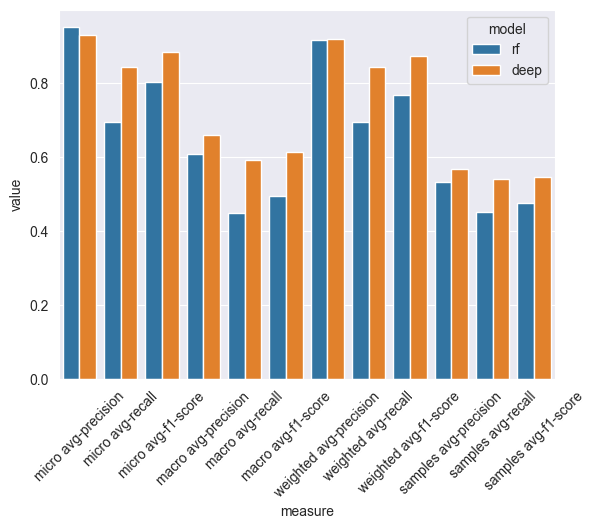

In [70]:

sns.barplot(x = 'measure', y = 'value', hue = 'model', data = df,
            palette = 'tab10', edgecolor = 'w')
# tips.groupby(['day','model']).mean()
# sns.set(font_scale = 5)
plt.xticks(rotation=45)
plt.savefig("model_comparison.jpg",dpi=300 )
plt.show()

In [16]:
# print(metrics.classification_report(y_pred, y_test))

In [17]:
# cm = accuracy_score(y_test, y_pred)
# cm

In [56]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred_rf)


In [81]:
labels =  y_test.columns

In [78]:
labels

[Index(['Planzeichen', 'Widmung', 'VerkehrsflaecheID',
        'AnordnungGaertnerischeAusgestaltung', 'Dachart', 'AnFluchtlinie',
        'VorkehrungBepflanzung', 'GebaeudeHoeheArt', 'BegruenungDach',
        'WidmungInMehrerenEbenen', 'AbschlussDachMaxBezugGebaeude',
        'BBAllgemein', 'ErrichtungGebaeude', 'GehsteigbreiteMin',
        'GebaeudeHoeheMaxAbsolut', 'GesamtePlangebiet', 'StrassenbreiteMin',
        'GebaeudeBautyp', 'Nutzungsart', 'UnterbrechungGeschlosseneBauweise',
        'AufbautenZulaessig', 'VonBebauungFreizuhalten', 'DachneigungMax',
        'Bauklasse', 'EinfriedungAusgestaltung', 'DurchgangBreite',
        'BebauteFlaecheMaxProzentual', 'AusnahmeGaertnerischAuszugestaltende',
        'StrassenbreiteMax', 'BauweiseID', 'DurchgangHoehe',
        'VolumenUndUmbaubarerRaum', 'UnterirdischeBaulichkeiten',
        'Struktureinheit', 'Stockwerk', 'EinfriedungHoeheGesamt',
        'DachflaecheMin', 'BebauteFlaecheMax',
        'VerbotFensterZuOeffentlichenVerkehrsfla

In [82]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

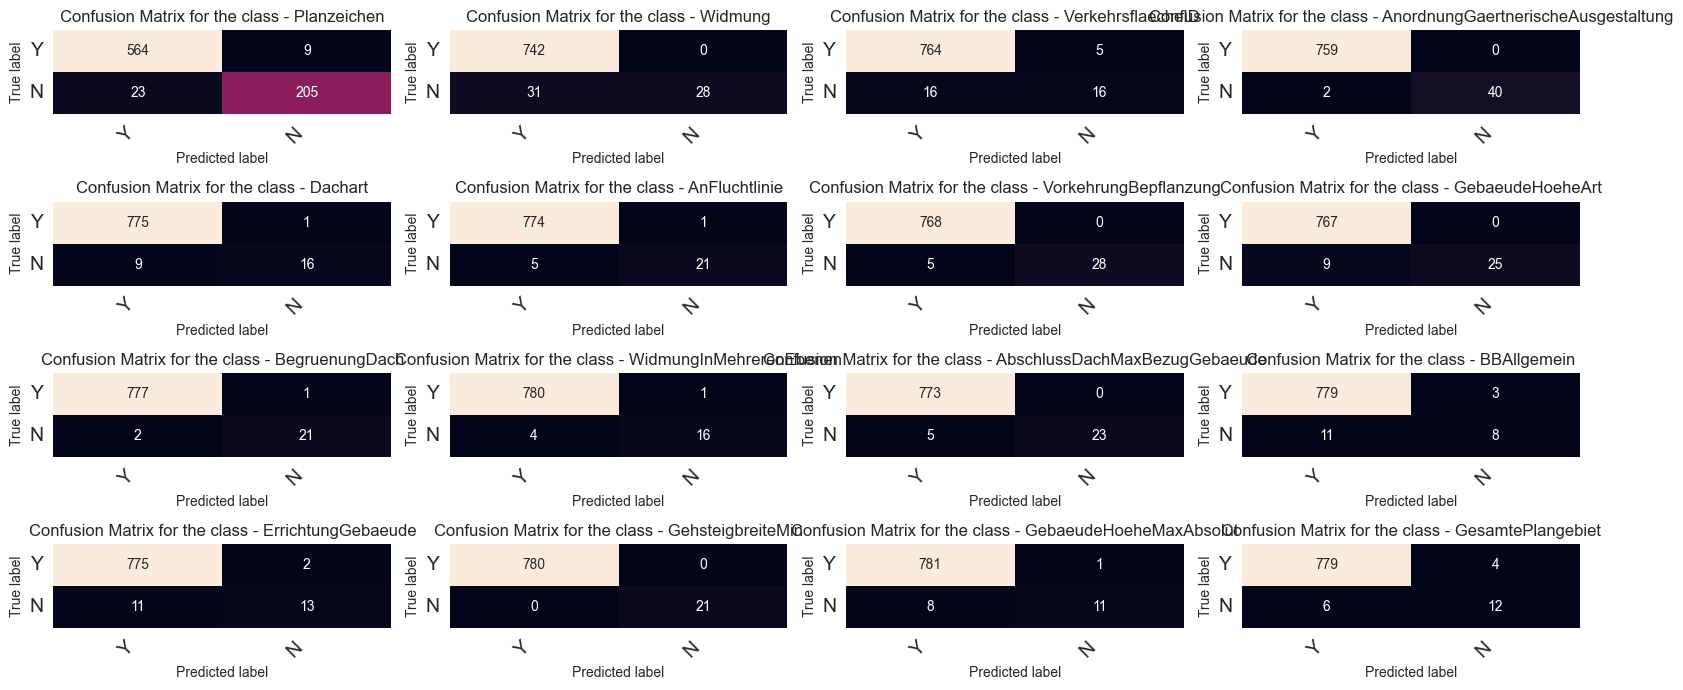

In [85]:
fig, ax = plt.subplots(4, 4, figsize=(16, 7))

for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])

fig.tight_layout()
plt.show()

# metrics for multi-label classification

We have unbalanced classes, so accuracy is not a good metric. Better precision,recall, f1-score etc.
For each class, we can compute the usual metrics for binary classification, and the confusion matrix.

Aggregate metrics like macro, micro, weighted and sampled avg give us a high-level view of how our model is performing.

## macro average
This is simply the average of a metric — precision, recall or f1-score — over all classes.

## Micro average
The micro-average of a metric is calculated by considering all the TP, TN, FP and FN for each class, adding them up and then using those to compute the metric’s micro-average

## Weighted average
This is simply the average of the metric values for individual classes weighted by the support of that class. The support is how many times a class appeared in y_test.

## Samples average
Here, we compute metrics for each sample and then average them.